## Final Project Submission

Please fill out:
* Student name: Aaron Lee
* Student pace: self paced
* Scheduled project review date/time: #########
* Instructor name: Jeff Herman
* Blog post URL: ###########


# The Project

Our client sees all the big companies creating original video content, and they want to get in on the fun. They have decided to create a new movie studio, but need help in understanding the movie industry. This project will provide a data analysis and presentation that explores what type of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the CEO can use when deciding what type of films they should be creating.

## TMDB database

For our research, we will be using "The Movie Database" (TMDB) API to access the the box office info we need.  TMDB has access to over half a million movies and provides detailed data about genres, budgets, revenues, and other data we will need for our project.  Below are some examples of API calls for TMDB.  

## Accessing database
Below is the code we used to access our local API keys for TMDB.  
API tokens and keys can be attained at https://www.themoviedb.org/

In [792]:
# Access TMDB
import json
import pandas as pd

def get_keys(path):
    with open(path) as f:
        return json.load(f)
    

keys = get_keys("/Users/aaronlee/.secret/tmdb_api.json")

api_key = keys['api_key']
api_key4 = keys['api_key4']


# TMDB database queries
The TMDB database can be queried as shown in the code below.  Many examples can be found online, and the developer API guide on the website is very useful.

In [793]:
# useful urls to access tmdb
base_url = 'https://api.themoviedb.org/3/'
# add the following for more specific searches
# /person/person_id (actors/directors info)
# /movie/movie_id (movie details)
# /keywords/[keys] (general search query)
# /discover/movie. (get movies collections)


# Sample queries

# 2017 highest grossing
params = {'primary_release_year': 2017,
          'sort_by': 'revenue.desc'
         }

# highest revenue Tom Cruise scifi movie
params = {'with_genres': 878,
          'with_cast': 500,
          'sort_by': 'revenue.desc'
        }


# Commented out on next line is a proper request
# response = requests.get(base_url + 'discover/movie?api_key=' +  api_key, params=params)

# On the retrieved page, movie details are located in response.json()['results']


# Selecting our sample

First, we create an API request to get 1000 movies from the past five years sorted by budget (2015-2019).  This will give a large cross section of recent movies which have gone into wide theater release.  We chose not to use data from 2020 due to the COVID-19 pandemic.  


In [794]:
import requests


# We will get the top n(sample size) number of movies from the indicated range of years
# TMDB displays 20 per page.  Thats 50 pages worth!

def movie_selection_query(n, start_year, end_year):
    """Get a list of movie data.
    Args:
        n (int): number of movies to grab.
        start_year (int): earliest production year for movies returned
        end_year (int): latest production year for movies returned
    Returns:
       list: each index is a dict representing api results for single movie.
    """
    pages = 1 + n // 20 # db returns 20 results per page
    list_of_dicts = []  # list to be returned
    print("Fetching page ", end=(""))

    for i in range(1, pages + 1):
        # each iteration and api call is for a single page (20 movies)
        params = {
                  'primary_release_year.gte': start_year,
                  #'primary_release_year.lte': end_year,
                  'sort_by': 'revenue.desc',
                  'page': i,
                  'adult': False}
        
        #Fetch Movie Data
        response = requests.get(base_url + 'discover/movie?api_key=' +  api_key, params=params)
        print(i, end=(','))
        # Go through results and add each to movie dict
        for movie in response.json()['results']:
            list_of_dicts.append(movie)
    
    print('-fetched all pages')
    return list_of_dicts[:n]

sample_size = 5000
start_year = 2010
end_year = 2019
all_my_movies = movie_selection_query(sample_size, start_year, end_year)
          
all_my_movies[0]

Fetching page 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,-fetched all pages


{'popularity': 0,
 'vote_count': 0,
 'video': False,
 'poster_path': '/vhcakM12qXDGKTpcbOQTg1egDMB.jpg',
 'id': 693704,
 'adult': False,
 'backdrop_path': '/AotyNSm6ZsqJ6sbRv3VTmtiOIeV.jpg',
 'original_language': 'en',
 'original_title': 'Yankee With No Brim',
 'genre_ids': [27, 10749],
 'title': 'Yankee With No Brim',
 'vote_average': 0,
 'overview': "A man's reality is shaken when, while filming, he discovers one man's bold secret.",
 'release_date': '2020-01-02'}

### Get all the movie id numbers from the query
We have retrieved the basic info for each movie.  This includes the movie 'id' number which will help us fetch the detailed info for each movie.  

Below, we extract all the movie 'id's from the previous 1000 movie query.  

In [795]:
all_my_movies[0]  # look at data for first movie

# lets grab all of the movie numbers
movie_ids = [movie['id'] for movie in all_my_movies]

movie_ids.pop(0)  #  The first item from the query is apparently an erroneous response.  It is popped from the list. 

693704

### Make API call for each movie to grab detailed info
Now that we can the movie 'id' for TMDB, we can do a detailed movie api call for all of the selected movies.  This data includes: title, revenue, budget, runtime, etc.  

In [796]:
all_movie_details = []

i = 1
print("Fetching movies")
for movie in movie_ids:
    #Fetch Movie Data
    #print(movie, end=',')
    print('', end='.')
    movie_response = requests.get(base_url + 'movie/' + str(movie) + '?api_key=' +  api_key)
    #print(movie_response)
    all_movie_details.append(movie_response.json())
    i += 1
    
print("--end of queries.")

Fetching movies
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [805]:
len(all_movie_details)
all_movie_details

{'adult': False,
 'backdrop_path': '/orjiB3oUIsyz60hoEqkiGpy5CeO.jpg',
 'belongs_to_collection': {'id': 86311,
  'name': 'The Avengers Collection',
  'poster_path': '/bvjltR2nDuhf1NlnwCrgNwvHuIh.jpg',
  'backdrop_path': '/zuW6fOiusv4X9nnW3paHGfXcSll.jpg'},
 'budget': 356000000,
 'genres': [{'id': 12, 'name': 'Adventure'},
  {'id': 878, 'name': 'Science Fiction'},
  {'id': 28, 'name': 'Action'}],
 'homepage': 'https://www.marvel.com/movies/avengers-endgame',
 'id': 299534,
 'imdb_id': 'tt4154796',
 'original_language': 'en',
 'original_title': 'Avengers: Endgame',
 'overview': "After the devastating events of Avengers: Infinity War, the universe is in ruins due to the efforts of the Mad Titan, Thanos. With the help of remaining allies, the Avengers must assemble once more in order to undo Thanos' actions and restore order to the universe once and for all, no matter what consequences may be in store.",
 'popularity': 46.572,
 'poster_path': '/or06FN3Dka5tukK1e9sl16pB3iy.jpg',
 'productio

### Convert to DataFrame and filter out 
With detailed info on every movie in our search, we can finally put it all into a Panda dataframe for further investigation.  We will attempt to look at major trends in movies for a new production company, so we will check the data as it relates primarily to budget and revenue.  We will attempt to inform the company what types of movies will be profitable going forward. 

In [819]:
df = pd.DataFrame(all_movie_details)

## Filter results
Any movies with no vote counts from TMDB users were filtered out.  This was to eliminate several erroneous entries. 
Movies with runtimes under one hour were removed to eliminate several shorts and bonus material videos from being included.
Movies with a budget or revenue under $500,000 are removed to eliminate movies which did not have wide releases.

These filters seemed to remove any missing or NaN values that would affect our analysis.

In [829]:


# convert dates to datetime objects for comparison
datetimes = pd.to_datetime(df["release_date"])
#print(datetimes)

df['release_date'] = datetimes

# 10 years of movies
df10 = df[(df['vote_count'] > 0) 
        &  (df['revenue'] > 5e5) 
        & (df['budget'] > 5e5)
        & (df['release_date'] > '2010-01-01')
        & (df['release_date'] < '2020-01-01')
       ]  # get rid of shorts and non voted

# 5 years of movies
df5 = df[(df['vote_count'] > 0) 
        & (df['runtime'] > 60) 
        & (df['revenue'] > 5e5) 
        & (df['budget'] > 5e5)
        & (df['release_date'] > '2015-01-01')
        & (df['release_date'] < '2020-01-01')
       ]  # get rid of shorts and non voted

 

df5.isna().sum()  # all the data will work for our purposes.  We might later drop some cols to simplify
df5.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count,status_code
count,7.120000e+02,712.000000,712.000000,7.120000e+02,712.000000,712.000000,712.000000,0.0
mean,5.269440e+07,354558.884831,20.416844,1.972402e+08,115.276685,6.586517,2820.259831,NaN
std,5.796186e+07,102989.643888,22.527115,3.034131e+08,19.617814,0.802414,3327.111450,NaN
min,7.000000e+05,14564.000000,0.888000,1.181728e+07,81.000000,3.400000,6.000000,NaN
25%,1.200000e+07,290712.000000,11.763000,3.469804e+07,100.000000,6.000000,620.750000,NaN
50%,3.000000e+07,347738.000000,16.406500,8.080147e+07,112.500000,6.600000,1644.500000,NaN
75%,6.900000e+07,429191.000000,24.556500,2.129224e+08,127.000000,7.100000,3849.250000,NaN
max,3.560000e+08,620683.000000,490.159000,2.797801e+09,188.000000,8.500000,22596.000000,NaN


# Budget and Revenue 
Our investigation will be focused on the budget and revenues of movies.
We begin by exploring these for our set of movies. by looking at the centerl tendencies.

In [830]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print("Budget and Revenue (past 5 years)\n")

print("Budget Centeral Tendency")
print('Min Budget: {:.2f} Million'.format(df5['budget'].min() / 1e6))
print('Max Budget: {:.2f} Million'.format(df5['budget'].max() / 1e6))
print('Mean Budget: {:.2f} Million'.format(df5['budget'].mean() / 1e6))
print('Median Budget: {:.2f} Million'.format(df5['budget'].median() / 1e6))
print('First Quartile (25%): {:.2f} Million'.format(df5['budget'].quantile(0.25) / 1e6))
print("IQR (25-50%): {:.2f} Million".format((df5['budget'].quantile(0.75) - df5['budget'].quantile(0.25)) / 1e6))
print('Third Quartile (75%): {:.2f} Million'.format(df5['budget'].quantile(0.75) / 1e6))
print("Std Dev: {:.2f} Million".format(df5['budget'].std() / 1e6))

print("\nRevenue Central Tendency")
print('Min Revenue: {:.2f} Million'.format(df5['revenue'].min() / 1e6))
print('Max Revenue: {:.2f} Million'.format(df5['revenue'].max() / 1e6))
print('Mean Revenue: {:.2f} Million'.format(df5['revenue'].mean() / 1e6))
print('Median Revenue: {:.2f} Million'.format(df5['revenue'].median() / 1e6))
print('First Quartile (25%): {:.2f} Million'.format(df5['revenue'].quantile(0.25) / 1e6))
print("IQR (25-50%): {:.2f} Million".format((df5['revenue'].quantile(0.75) - df['revenue'].quantile(0.25)) / 1e6))
print('Third Quartile (75%): {:.2f} Million'.format(df['revenue'].quantile(0.75) / 1e6))
print("Std Dev: {:.2f} Million".format(df['revenue'].std() / 1e6))


# df.info()
# df.describe()
# df['budget'].describe()
# df['revenue'].describe()

Budget and Revenue (past 5 years)

Budget Centeral Tendency
Min Budget: 0.70 Million
Max Budget: 356.00 Million
Mean Budget: 52.69 Million
Median Budget: 30.00 Million
First Quartile (25%): 12.00 Million
IQR (25-50%): 57.00 Million
Third Quartile (75%): 69.00 Million
Std Dev: 57.96 Million

Revenue Central Tendency
Min Revenue: 11.82 Million
Max Revenue: 2797.80 Million
Mean Revenue: 197.24 Million
Median Revenue: 80.80 Million
First Quartile (25%): 34.70 Million
IQR (25-50%): 188.58 Million
Third Quartile (75%): 128.03 Million
Std Dev: 189.61 Million


Promotional and other costs are not considered as part of this study, so the true results are incomplete.  However, mean revenues are more than five times the mean budget.  Movies with budgets in the Third Quartile (90M USD) are still smaller than revenues in the First Quartile (109M USD).  This is further illustrated by the box plots below.

[Text(0.5, 0, 'Millions (USD))')]

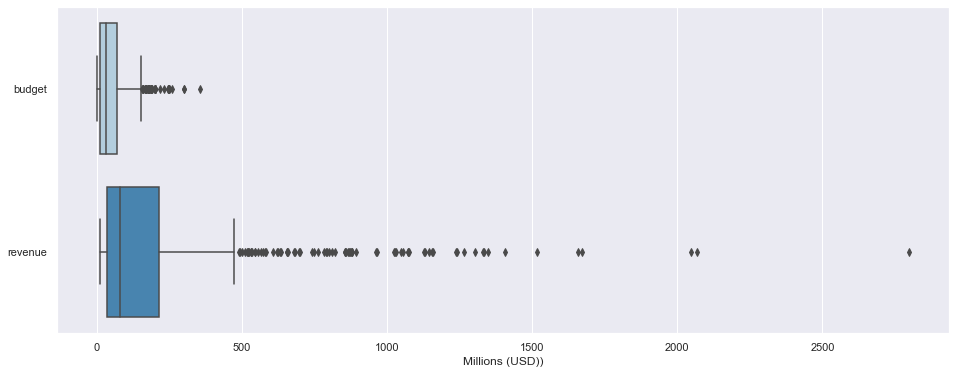

In [831]:
# df with just revenue and budget
df_returns = df5[['budget', 'revenue']].copy()

sns.set_style('darkgrid')
dims = (6, 18)

# df with just revenue and budget
df_returns = df5[['budget', 'revenue']].copy()

sns.set_style('darkgrid')
sns.set_context("notebook")


dims = (18, 6)


#sns.boxplot(data=df_returns, palette='Reds')
# xlabels = ['{:d}'.format(int(x/1000000)) for x in ax.get_xticks()]
# ax.set_title("Revenue for Major Theaterical Releases")
# ax.set_xticklabels(xlabels)
# ax.set(xlabel='Millions (USD)')

plt.figure(figsize=(16, 6))

ax = sns.boxplot(data=df_returns, palette='Blues', orient='h')
xlabels = ['{:d}'.format(int(x/1000000)) for x in ax.get_xticks()]
ax.set_xticklabels(xlabels)
ax.set(xlabel="Millions (USD))")



## Distribution of Budgets and Revenues

[Text(0.5, 0, 'Millions (USD)')]

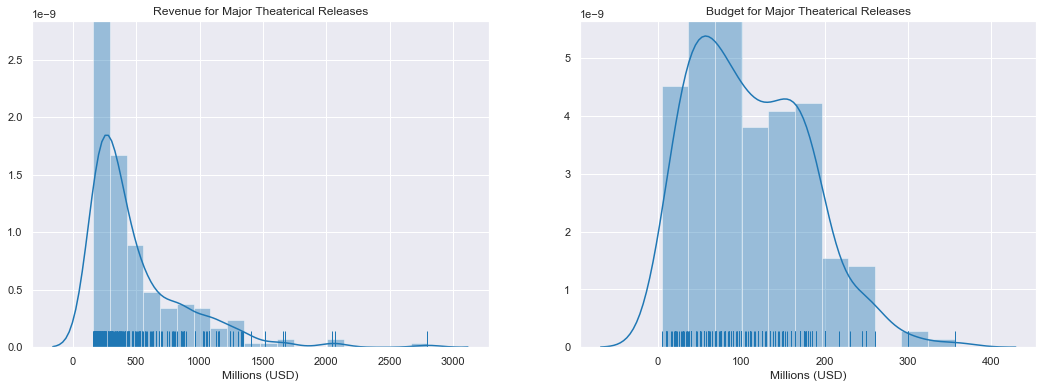

In [759]:
dims = (18, 6)
fig, ax = plt.subplots(1, 2, figsize=dims)

# Revenue histo plot
sns.distplot(df['revenue'], ax=ax[0], rug=True) 
ax[0].set_title("Revenue for Major Theaterical Releases")
xlabels = ['{:d}'.format(int(x/1000000)) for x in ax[0].get_xticks()]
ax[0].set_xticklabels(xlabels)
ax[0].set(xlabel='Millions (USD)')


# Budget regression plot
sns.distplot(df['budget'], ax=ax[1], rug=True) 
ax[1].set_title("Budget for Major Theaterical Releases")
xlabels = ['{:d}'.format(int(x/1000000)) for x in ax[1].get_xticks()]
ax[1].set_xticklabels(xlabels)
ax[1].set(xlabel='Millions (USD)')

# Spacing between if we put them on top of each other to share axis
# ax[1].set_xlim([0, 3000000000])
# ax[0].set_xlim([0, 3000000000])
# plt.tight_layout()
# plt.subplots_adjust(top=0.8)


Both budget and revenue are left skewed, and returns tend to be significantly higher than budgets, with revenue outliers on the high side being far more prevalent than budget outliers.

# What Affects Revenue?
Now we will attempt to find correlations between movie attributes and the revenue data.
Specifically, our client wants to know what kind of movie they should be making for the current market.  We must look at genre, sequels, runtime, etc.

Text(0.5, 1, 'Pearson Coefficients')

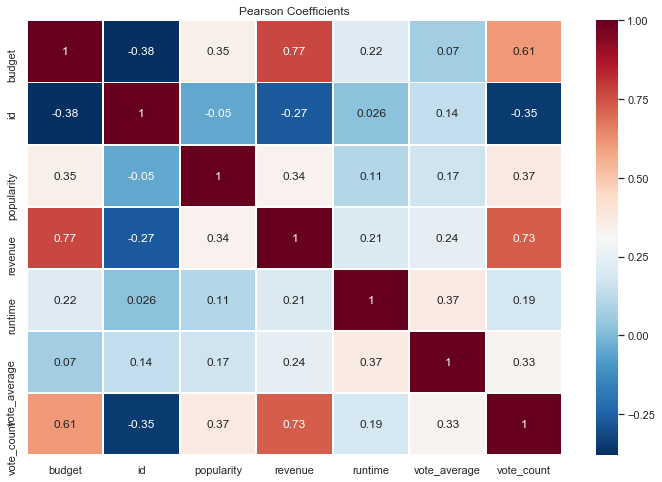

In [834]:
import numpy as np

try:
    df5.drop(columns=['status_code', 'status_message'], inplace=True)
except:
    pass


pearsoncorr = df5.corr(method ='pearson') 
plt.figure(figsize=(12,8))

# this works in matplotlib 
ax = sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=1)

#df.columns
ax.set_ylim(7.0, 0)
ax.set_title('Pearson Coefficients')




The coefficients above that stick out as having high positive corelations are **budget** and **revenue**.  of course user_votes is also linked closely to revenue (people see movies they like).  

From the above heatmap, we should look at the following numerical data:
- budget: high degree of correlation with revenue</li>
- runtime: low degree correlation</li>


There is also likely a correlation with other some categorical information about the movie such as:
- is the movie a sequel or part of a franchise?</li>
- what is the genre of the movie?</li>
- what month or date was the release?</li>




# Relationship between a movie's budget and revenue
The numerical category with the highest correlation is user votes for the movie.  Making quality movies that are liked by audiences is likely the best way to guarantee high returns.  Additionally, the budget seems to have a high degree of correlation with revenue, and we will look at that relationship now. 

Text(0.5, 1, 'Pearson Corr: 0.77')

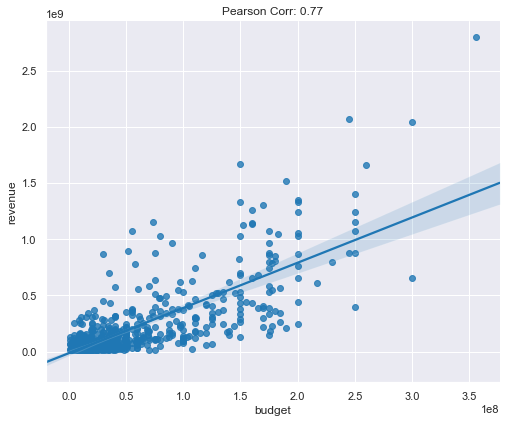

In [835]:
# calculate pearson corr for budget revenue
pval = df5[['budget', 'revenue']].corr(method ='pearson').iloc[0,1]

# make regression plot
fgrid = sns.lmplot(data=df5, x='budget', y='revenue', height=6, aspect=1.2)

# annotate with pval
ax = fgrid.axes[0,0] 
ax.set_title('Pearson Corr: {:.2f}'.format(pval))


# How has this relationship changed over time?

0.7857885251148837
0.7346309906551868
0.7854824932738818
0.7358075145342516
0.8661812181308244
0.7586509822159415
0.7722261813392955
0.7527724518951926
0.7926475055375759
0.8008793938818561


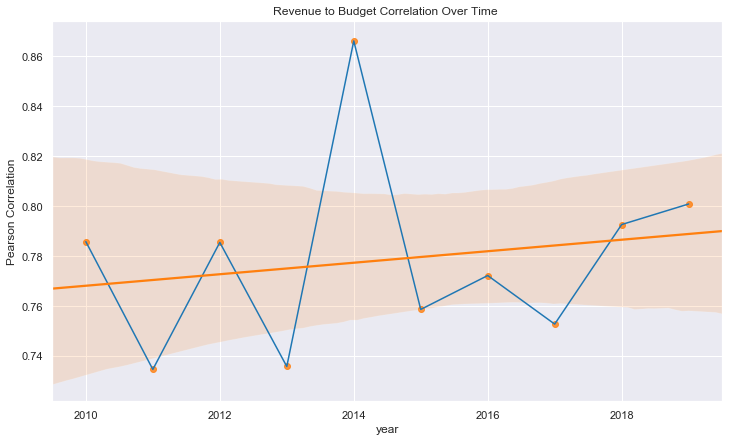

In [841]:

# make a new year col
df_date = df10.copy()

df_date['release_year'] = pd.DatetimeIndex(df_date['release_date']).year

corrs = [] 

start_year = 2010
end_year = 2019
for year in range(start_year, end_year + 1):
    rev = df_date[df_date['release_year'] == year]['revenue']
    bud = df_date[df_date['release_year'] == year]['budget']
    c = rev.corr(bud, method='pearson')
    print(c)
    corrs.append({'year': int(year), 'Pearson Correlation': c})

corrs

df_corrs = pd.DataFrame(corrs)

plt.figure(figsize=(12,7))
ax = sns.lineplot(data=df_corrs, x='year', y='Pearson Correlation')
ax.set_title("Revenue to Budget Correlation Over Time ")
sns.regplot(data=df_corrs, x='year', y='Pearson Correlation')



## Return on Investment for big budget films

We will look at films that are in the top 10% for budgets and compare them to the rest of the field.

Text(0.5, 1, 'Pearson Corr: 0.58')

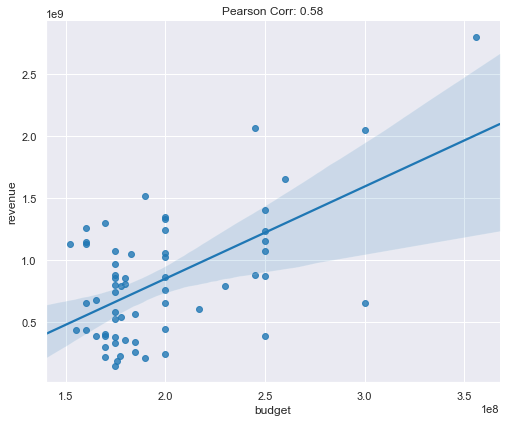

In [843]:
# calculate pearson corr for budget revenue
# 5 years of movies
df5_big = df5[(df5['budget'] > df5['budget'].quantile(0.9))]  # get rid of shorts and non voted


pval = df5_big[['budget', 'revenue']].corr(method ='pearson').iloc[0,1]

# make regression plot
fgrid = sns.lmplot(data=df5_big, x='budget', y='revenue', height=6, aspect=1.2)

# annotate with pval
ax = fgrid.axes[0,0] 
ax.set_title('Pearson Corr: {:.2f}'.format(pval))


# Do movie franchises fare significantly better than standalone films?

The database used for this study only shows if the film was part of a franchise, meaning that even the first film in a series would be categorized as any other franchise movie.  Since we generally expect that only successful movies are given sequels, this will greatly skew the result.  A closer look at true sequels might be a subject for further study.

Pearson Correlations:
	Franchise: 0.78
	No Franchise: 0.66


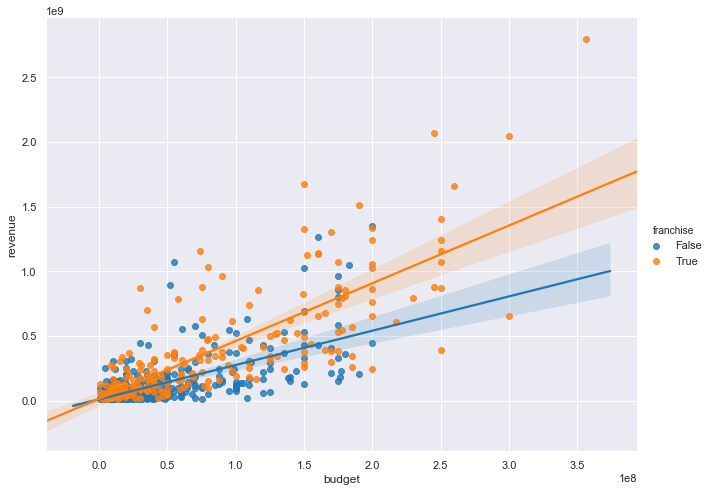

In [902]:
from scipy import stats


df5.loc['franchise'] = df5.loc[:, ('belongs_to_collection')].notna()
#slope, intercept, r_value, p_value, std_err = stats.linregress(df5['budget'],df5['revenue'])
#print("Slope:", slope)

ax = sns.lmplot(x="budget", 
                y="revenue", 
                hue="franchise", 
                data=df5, 
                height=7, 
                aspect=1.3,
               )  # use this for genre later.  Plots columns using cols='genre'!!

# add pval
pval_yes = df5.loc[df5['franchise']==True, ['budget', 'revenue']].corr(method ='pearson').iloc[0,1]
pval_no = df5.loc[df5['franchise']==False, ['budget', 'revenue']].corr(method ='pearson').iloc[0,1]
print("Pearson Correlations:\n\tFranchise: {:.2f}\n\tNo Franchise: {:.2f}".format(pval_yes, pval_no))

[Text(0.5, 0, 'Millions (USD))')]

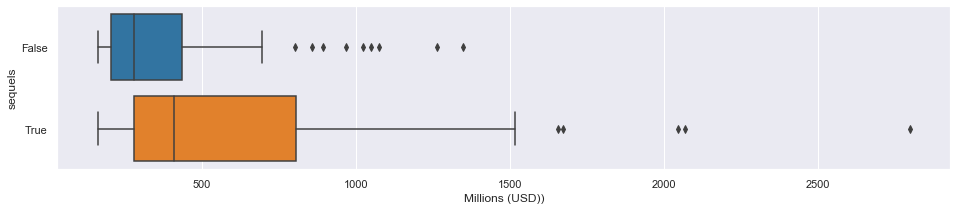

In [765]:
df_sequels = df[['sequels', 'revenue']]
df_sequels


plt.figure(figsize=(16,3))
ax = sns.boxplot(data=df_sequels, x='revenue', y='sequels', orient='h')


xlabels = ['{:d}'.format(int(x/1000000)) for x in ax.get_xticks()]
ax.set_xticklabels(xlabels)
ax.set(xlabel="Millions (USD))")



# What about genres?

TMDB provides a dictionary of all genres provided for a movie (up to 3).  This makes it difficult to categorize a movie by a single genre.  A "RomCom" might best be described by both categories, but the database only has categores of Romance and Comedy separate.  The first category is the primary category for the movie and will be used for the following analysis.

Empty DataFrame
Columns: [genre, revenue]
Index: []


Text(0.5, 1.0, 'Revenue by Genre')

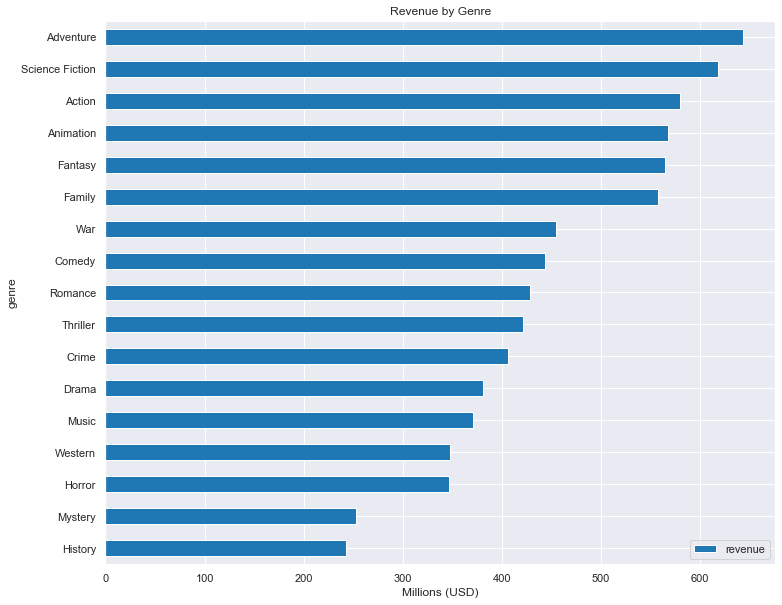

In [791]:
###################DO NEXT!!
df.iloc[0]
df_genres = df.copy()

df_genres = df_genres[['genres', 'revenue']]
df_genres.head()

# make df that has separate entry for each genre.  A movie with three genres would effect three categories.
df_gen_exp = pd.DataFrame({'genre':[], 'revenue':[]})
print(df_gen_exp)
max_genres = 0


for col, row in df_genres.iterrows():
    if len(row['genres']) > max_genres:
        #print(max_genres)
        max_genres = len(row['genres'])
    for genres in row['genres']:
        new = pd.DataFrame({'genre':[genres['name']], 'revenue':[row['revenue']]})
        df_gen_exp = pd.concat([df_gen_exp, new])
        


#print(df_gen_exp.head(20))
#print(max_genres)

        
        
# for i in range(len(df)):
#     df_genres.loc[i, 'genre'] = df.iloc[i]['genres'][0]['name']

    
    
    
df_genres_grouped = df_gen_exp.groupby(['genre']).mean().sort_values('revenue')
df_genres_grouped = df_genres_grouped[['revenue']]
df_genres_grouped
                                 
ax = df_genres_grouped.plot.barh(figsize=(12,10))

xlabels = ['{:d}'.format(int(x/1000000)) for x in ax.get_xticks()]
ax.set_xticklabels(xlabels)
ax.set(xlabel='Millions (USD)')
ax.set_title("Revenue by Genre")

# I first wanted to make budget revenue graphs for all genres, but wasn't that useful
# make a column for a primary genre (many movies have dicts with multiples)
#sns.lmplot(x='budget', y="revenue", col="genre", data=df_genres, col_wrap=2, hue='genre')  # use this for genre later.  Plots columns!!


In [ ]:
# let's continue to look at genres, but now lets plot the trends of each genre over past 10 years



1076857485.1500006


[Text(0.5, 0, '')]

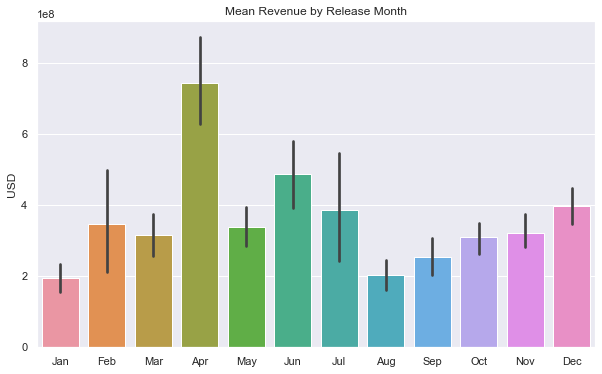

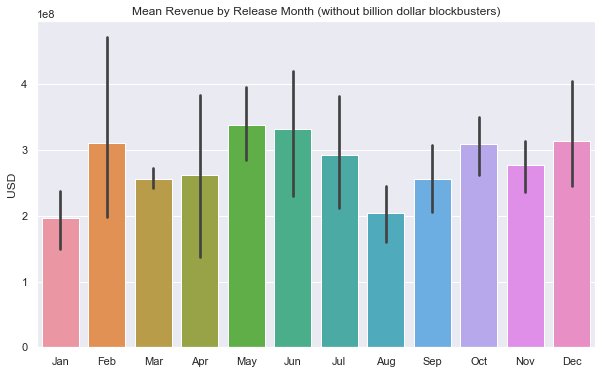

In [747]:


# investigate release date effect
import datetime as dt
df_month = df.loc[:, ['release_date', 'revenue']]


#df_month['release_date'].map(split(''))
# # create a new col for release month
# df_month['release_month'] = df_month['release_date'].map(lambda x: x.split('-')[1])
# df_month['release_year'] = df_month['release_date'].map(lambda x: x.split('-')[2])

df_month['release_month'] = pd.DatetimeIndex(df_month['release_date']).month
df_month['release_year'] = pd.DatetimeIndex(df_month['release_date']).year


df_month

df_month = df_month.groupby(['release_year', 'release_month']).mean().reset_index()
df_month

# # Revenue regression plot
plt.figure(figsize=(10,6))
ax = sns.barplot(data=df_month, x='release_month', y='revenue') 
ax.set_title("Mean Revenue by Release Month")
xlabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_xticklabels(xlabels)
ax.set(ylabel='USD')
ax.set(xlabel="")





# Try this again removing megablockbuster outliers to see the trends better
# investigate release date effect
df_month = df.loc[:, ['release_date', 'revenue']]

# blockbuster will be 95th quantile
blockbuster = df_month['revenue'].quantile(0.95)
print(blockbuster)

df_month = df_month[df_month['revenue'] < blockbuster] 



# create a new col for release month
df_month['release_month'] = pd.DatetimeIndex(df_month['release_date']).month
df_month['release_year'] = pd.DatetimeIndex(df_month['release_date']).year

df_month = df_month.groupby(['release_year', 'release_month']).mean().reset_index()
df_month

# # Revenue regression plot
plt.figure(figsize=(10,6))
ax = sns.barplot(data=df_month, x='release_month', y='revenue') 
ax.set_title("Mean Revenue by Release Month (without billion dollar blockbusters)")
xlabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_xticklabels(xlabels)
ax.set(ylabel='USD')
ax.set(xlabel="")

The April release date being such an high performer seemed counterintuitive.  After looking at the highest grossing films, it appears that two Avengers movies were released in April over the timeframe of our study.  Those outliers added the larger than expected revenue and error bar for April.  A second graph removed blockbuster movies that made more than one billion dollars.


I think I want a graph of each genre and how many films were made by year.  Will be a tough one.

How about a ROI on blockbuster movies vs. small budget?